In [363]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import spectrogram, lfilter, freqz, tf2zpk, ellipord, ellip, find_peaks
import soundfile as sf
from IPython.display import Audio
from IPython.display import display

In [364]:
# xgerge01

SELECTED_MIDI = [40, 65, 82]                    # selected tones
SELECTED_MIDI_FREQ = [82.41, 349.23, 932.33]    # selected tones frequencies

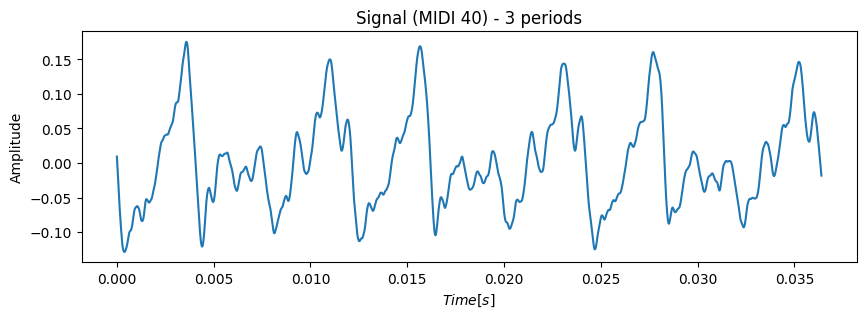

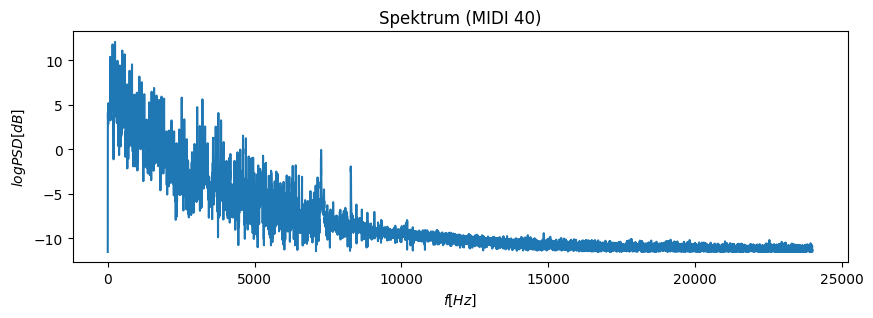

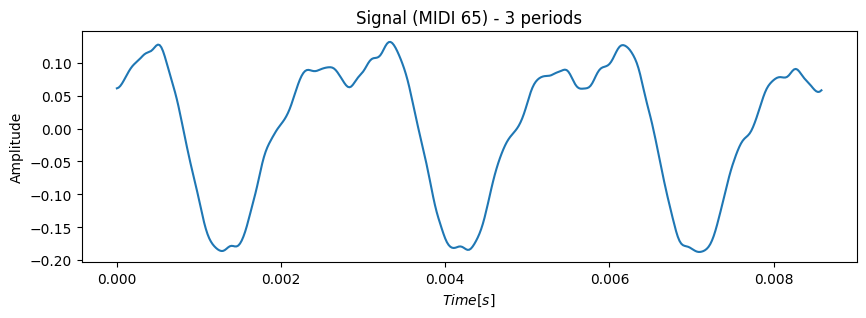

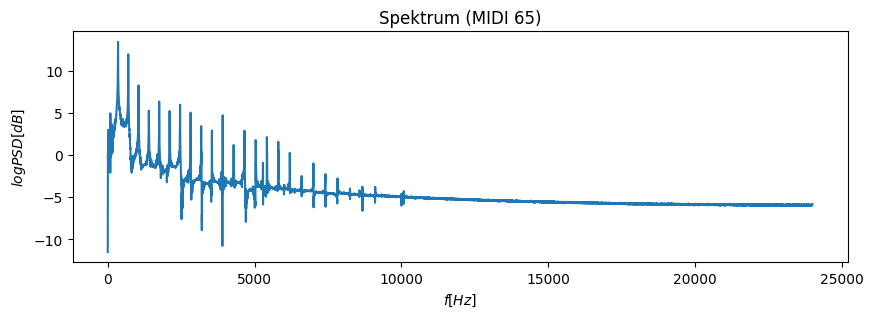

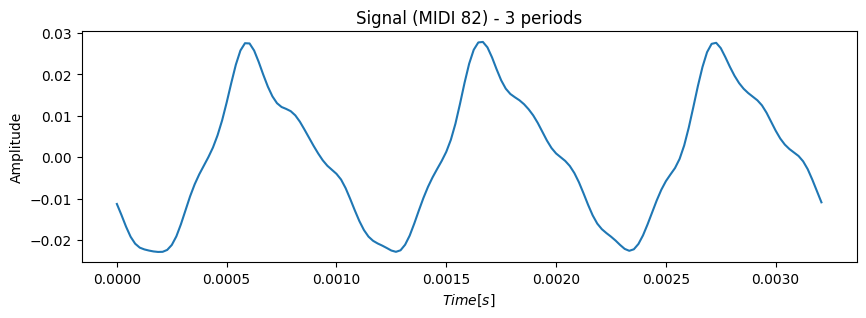

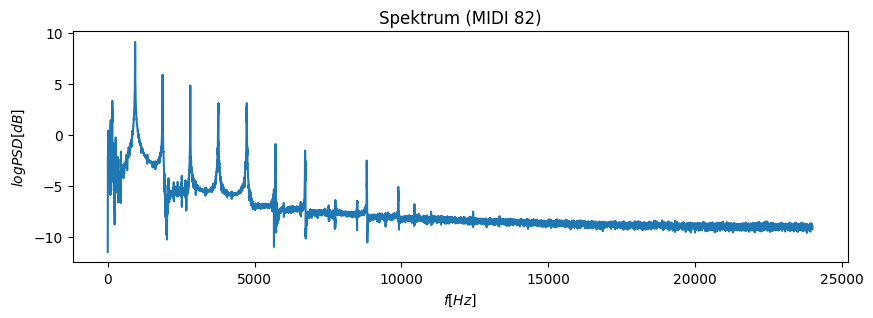

In [365]:
#  4.1 Základy

MIDIFROM = 24
MIDITO = 108

SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2

howmanytones = MIDITO - MIDIFROM + 1    # tone count
tones = np.arange(MIDIFROM, MIDITO+1)   # 24-108

s, Fs = sf.read('klavir.wav')           # read sound file

N = int(Fs * HOWMUCH_SEC)               # sample count for selected part of tone
Nwholetone = int(Fs * WHOLETONE_SEC)    # sample count for whole tone

xall = np.zeros((MIDITO+1, N))          # matrix (109 tones x 24000 samples) with all tones - first signals empty,
                                        # but we have plenty of memory ...
                             
samplefrom = int(SKIP_SEC * Fs)         # first tone to start from
sampleto = samplefrom + N               # first tone to end with

for tone in tones:
    x = s[samplefrom:sampleto]          # select part of tone
    x = x - np.mean(x)                  # safer to center ...
    xall[tone,:] = x                    # save tone to matrix

    samplefrom += Nwholetone            # next tone
    sampleto += Nwholetone              # next tone

tone_name_start = 'a'                   # selected tones start name
for i in range(len(SELECTED_MIDI)):
    tone_name = chr(ord(tone_name_start) + i)

    # save orig tone
    #display(Audio(xall[SELECTED_MIDI[i]], rate=Fs))
    sf.write('audio/%c_orig.wav' % tone_name, xall[SELECTED_MIDI[i]], Fs)

    # plot periods of tone
    num_periods = 3
    tone_period = Fs / SELECTED_MIDI_FREQ[i]
    time_steps = np.arange(0,num_periods*tone_period/Fs,step=1/Fs)
    plt.figure(figsize=(10, 3))
    plt.title('Signal (MIDI %d) - %d periods' % (SELECTED_MIDI[i], num_periods))
    plt.plot(time_steps, xall[SELECTED_MIDI[i]][:time_steps.size])
    plt.ylabel('Amplitude')
    plt.xlabel('$Time[s]$')
    plt.show()

    # dft
    X = np.fft.fft(xall[SELECTED_MIDI[i]])
    kall = np.arange(0, int(N/2) + 1)   # 0..N/2 
    Xmag = np.abs(X[kall])                        
    f = kall / N * Fs 

    spect = np.log(1e-5+Xmag**2)        # log PSD , +1e-5 to avoid log(0)

    # plot analysis
    plt.figure(figsize=(10,3))
    plt.title('Spektrum (MIDI %d)' % SELECTED_MIDI[i])
    plt.plot(f, spect)
    plt.ylabel('$logPSD[dB]$')
    plt.xlabel('$f[Hz]$')
    plt.show()

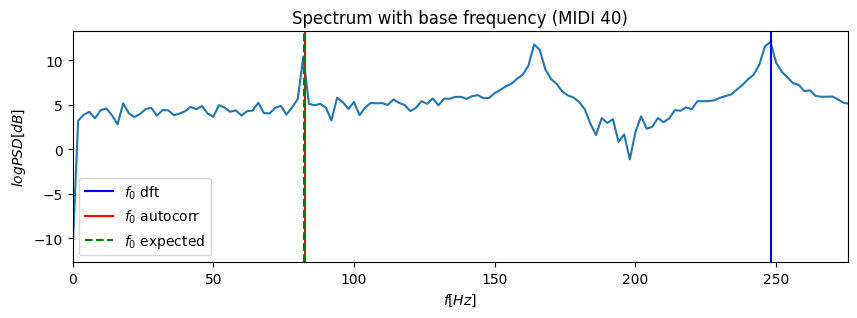

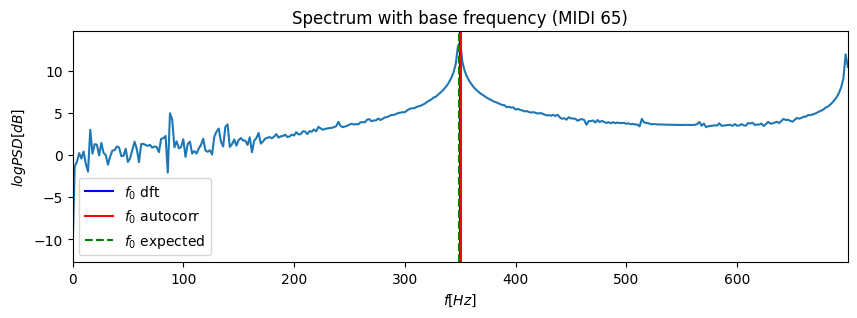

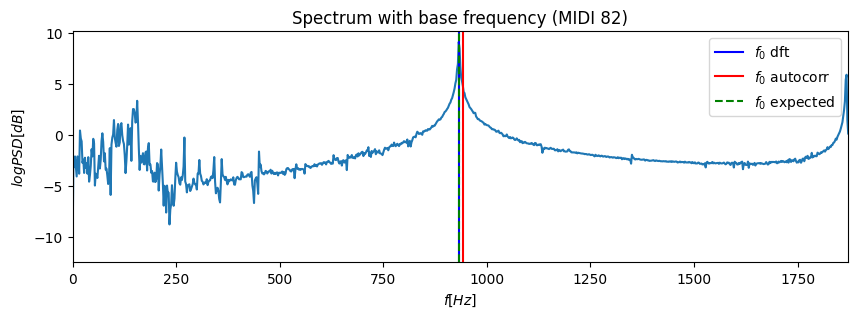

In [372]:
# 4.2 Určení základní frekvence

# load midi (expected) base frequencies from file
file_data = np.loadtxt('midi.txt')
file_data = file_data[:,1][::-1]
midi_fmax_orig = np.zeros(MIDITO+1)
midi_fmax_orig[MIDIFROM:MIDITO+1] = file_data

# get base frequency of MIDI tone with DFT and autocorrelation
midi_fmax_dft = np.zeros(MIDITO+1)
midi_fmax_ac = np.zeros(MIDITO+1)
for tone in tones:

    # dft
    X = np.fft.fft(xall[tone])
    kall = np.arange(0, int(N/2) + 1)   # 0..N/2         +1 ???
    Xmag = np.abs(X[kall])                        
    f = kall / N * Fs                   # kall -> fnorm -> f

    # find max
    midi_fmax_dft[tone] = f[np.argmax(Xmag)]

    # autocorrelation
    Rk = np.correlate(xall[tone], xall[tone], mode='full') / N
    Rk = Rk[Rk.size//2:]  # take only positive part

    # filter
    threshold = np.max(Rk) * 0.9
    Rk_filtered = np.where(Rk > threshold, Rk, 0)

    # first max peak is always at 0
    first_max_idx = np.argmax(Rk_filtered)

    # second max peak is first from found peaks
    peaks, _ = find_peaks(Rk_filtered)
    second_max_idx = peaks[0]

    period = second_max_idx - first_max_idx
    midi_fmax_ac[tone] = Fs / (period)

    # plt.figure(figsize=(10,3))
    # plt.title('Autokorelace (MIDI %d)' % tone)
    # plt.plot(Rk)
    # plt.plot(Rk_filtered, 'r--')
    # #plt.plot(peaks, Rk[peaks], "o")
    # plt.plot(first_max_idx, Rk[first_max_idx], 'ro')
    # plt.plot(second_max_idx, Rk[second_max_idx], 'go')
    # plt.ylabel('$R[k]$')
    # plt.xlabel('$k$')
    # plt.show()

    # plot my tones
    if tone in SELECTED_MIDI:
        
        spect = np.log(1e-5+Xmag**2)        # log PSD , +1e-5 to avoid log(0)

        # average of all frequencies
        freq_avg = np.mean([midi_fmax_dft[tone], midi_fmax_ac[tone], midi_fmax_orig[tone]])

        plt.figure(figsize=(10,3))
        plt.title('Spectrum with base frequency (MIDI %d)' % tone)
        plt.plot(f, spect)
        plt.axvline(midi_fmax_dft[tone], color='blue', linestyle='-', label='$f_0$ dft')
        plt.axvline(midi_fmax_ac[tone], color='red', linestyle='-', label='$f_0$ autocorr')
        plt.axvline(midi_fmax_orig[tone], color='green', linestyle='--', label='$f_0$ expected')
        plt.legend()
        plt.xlim([0,2*freq_avg])
        plt.ylabel('$logPSD[dB]$')
        plt.xlabel('$f[Hz]$')
        plt.show()

In [ ]:
#print all calculated base frequencies
for tone in tones:
    print('MIDI %d:\t %.2f Hz (expected),  %.2f Hz (DFT),  %.2f Hz (autocorr)' % (tone, midi_freq_orig[tone], midi_freq_dft[tone], midi_freq_ac[tone]))

# plt.figure(figsize=(10,3))
# plt.title('Base frequencies from DFT and autocorrelation')
# plt.yscale('log')
# plt.xlim([MIDIFROM, MIDITO])
# plt.plot(midi_freq_dft, 'b')
# plt.plot(midi_freq_ac, 'g')
# plt.plot(midi_freq_orig, 'r--')
# plt.legend(['dft', 'autocorr', 'expected'])
# plt.ylabel('$f[Hz]$')
# plt.xlabel('$MIDI$')
# plt.show()

In [368]:
# 4.3 Zpřesnění odhadu základní frekvence

for tone in tones:
    
    # dft
    X = np.fft.fft(xall[tone])
    kall = np.arange(0, int(N/2) + 1)   # 0..N/2 
    Xmag = np.abs(X[kall])                        
    f = kall / N * Fs 

    

    

In [ ]:

tone_name_start = 'a'                   # selected tones start name
for i in range(len(SELECTED_MIDI)):
    tone_name = chr(ord(tone_name_start) + i)

    # synthesis
    xs = np.fft.ifft(X)
    xs = np.real(xs)                # because of numerical computation ... 

    # plot synthesis
    plt.figure(figsize=(10,3))
    plt.plot(xall[SELECTED_MIDI[i]])
    plt.plot(xs)
    plt.show()

    # save synth tone
    #display(Audio(xs, rate=Fs))
    sf.write('audio/%c.wav' % tone_name, xs, Fs)

    _, ax = plt.subplots(3,1, figsize=(10,6))
    ax[0].plot(kall, Xmag)
    ax[0].text(0.4*N, max(Xmag)/2, '$k$',fontsize=18)
    fnorm = kall / N
    ax[1].plot(fnorm, Xmag)
    ax[1].text(0.4, max(Xmag)/2, '$f_{norm}$',fontsize=18)
    f = fnorm * Fs
    ax[2].plot(f, Xmag)
    ax[2].text(0.4*Fs, max(Xmag)/2, '$f$ [Hz]',fontsize=18)
